# Minimal code for Figure 1 flow cytometry panel

In [1]:
# library for reading .fcs files
suppressPackageStartupMessages(library(flowCore))
# library for extracting statistical fits
suppressPackageStartupMessages(library(broom))
# standard analysis and plotting functions, includes dplyr, ggplot2
suppressPackageStartupMessages(library(tidyverse))
# loads lab default ggplot2 theme and provides color-blind friendly palette
suppressPackageStartupMessages(library(rasilabRtemplates))
# this folder contains the data and annotations
fcs_file_folder <- c("../../../../data/flow_cytometry/fig1_eyfp_reporter_sgeyfp/day2/", 
                     "../../../../data/flow_cytometry/fig1_eyfp_reporter_sgeyfp/day5/", 
                     "../../../../data/flow_cytometry/fig1_eyfp_reporter_sgeyfp/day7/")
# nice channel names
channels <- c(
  "fitc_a" = "yfp", "pe_texas_rd_a" = "rfp",
  "bv421_a" = "bfp"
)

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Read in annotations

In [3]:
annotations <- read_csv("../annotations/sampleannotations.csv") %>% 
  print()

Rows: 3 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): sgrna
dbl (1): file

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 3 × 2
   file sgrna
  <dbl> <chr>
1   266 none 
2     5 fluc 
3     6 yfp  


## Read in flow data

In [4]:
flowdata  <- list.files(fcs_file_folder, full.names = T, pattern = ".fcs") %>% 
  as_tibble_col("file") %>%
  mutate(day = as.integer(str_extract(file, "(?<=day)."))) %>% 
  mutate(data = map(file, . %>% read.FCS(transformation = F, alter.names = T) %>% exprs %>% as_tibble)) %>%
  mutate(file = str_extract(file, "(?<=events_)[:graph:]+(?=.fcs$)")) %>%
  unnest("data") %>%
  janitor::clean_names() %>%
  rename_with(. %>% channels[.], names(channels)) %>%
  select(day, file, ssc_a, bfp, yfp, rfp) %>%
  type_convert() %>% 
  print()

Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FITC.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FITC.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FITC.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FITC.A' channel exceed its $PnR value 262144 and will be truncate

# A tibble: 90,000 × 6
     day  file ssc_a    bfp    yfp    rfp
   <int> <dbl> <dbl>  <dbl>  <dbl>  <dbl>
 1     2   266  23.3 1562.  -34.7  -40.8 
 2     2   266 225.  2205.   31.2   42.9 
 3     2   266 178.  2962.  -18.9   -9.29
 4     2   266  54.5 3339.   -5.93  36.6 
 5     2   266 180.    83.0 -16.7   24.9 
 6     2   266 161.  1844.   39.3   -5.40
 7     2   266 220.  3010.   10.2   12.5 
 8     2   266 130.   232.   28.7  113.  
 9     2   266 126.  1294.   -1.30 -34.5 
10     2   266 154.  2257.   29.4    8.80
# … with 89,990 more rows


## Join data with annotations

In [5]:
data <- flowdata %>% 
     inner_join(annotations, by = c("file")) %>% 
     print() 

# A tibble: 90,000 × 7
     day  file ssc_a    bfp    yfp    rfp sgrna
   <int> <dbl> <dbl>  <dbl>  <dbl>  <dbl> <chr>
 1     2   266  23.3 1562.  -34.7  -40.8  none 
 2     2   266 225.  2205.   31.2   42.9  none 
 3     2   266 178.  2962.  -18.9   -9.29 none 
 4     2   266  54.5 3339.   -5.93  36.6  none 
 5     2   266 180.    83.0 -16.7   24.9  none 
 6     2   266 161.  1844.   39.3   -5.40 none 
 7     2   266 220.  3010.   10.2   12.5  none 
 8     2   266 130.   232.   28.7  113.   none 
 9     2   266 126.  1294.   -1.30 -34.5  none 
10     2   266 154.  2257.   29.4    8.80 none 
# … with 89,990 more rows


## Plot data

Picking joint bandwidth of 0.0674

Warning message:
“Removed 298 rows containing non-finite values (`stat_density_ridges()`).”
Picking joint bandwidth of 0.0674

Warning message:
“Removed 298 rows containing non-finite values (`stat_density_ridges()`).”


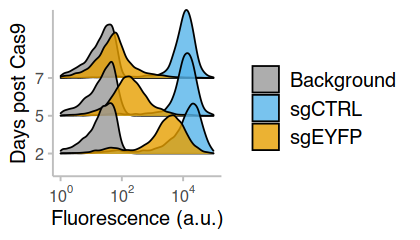

In [7]:
options(repr.plot.width = 3.5, repr.plot.height = 2)

plot_data <- data %>%
  # # collapse all channels
  pivot_longer(c("bfp", "yfp", "rfp", "ssc_a"), names_to = "channel") %>% 
  filter(channel %in% c("yfp")) %>% 
  mutate(sgrna = case_when(
    sgrna == "none" ~ "Background",
    sgrna == "fluc" ~ "sgCTRL",
    sgrna == "yfp" ~ "sgEYFP",
  )) %>%
  # filter(sgrna == "sgEYFP") %>% 
  mutate(channel = case_when(
    channel == "yfp" ~ "EYFP",
  )) %>%
  filter(value >= 1) %>%
  write_csv("../../../../source_data/figure_1b.csv")

plot_data %>%
  ggplot(aes(x = value, y = as.factor(day), fill = sgrna)) +
  ggridges::geom_density_ridges(alpha = 0.8) +
  scale_x_log10(limits = c(1, 1e5), breaks = scales::trans_breaks("log10", function(x) 100^x),
  labels = scales::trans_format("log10", scales::math_format(10^.x))) +
  # annotation_logticks(sides = "b") +
  scale_fill_manual(values = cbPalette[c(1,3,2)]) +
  labs(x = "Fluorescence (a.u.)", y = "Days post Cas9", fill = "") +
  theme(axis.line = element_line(color = "grey"),
  axis.ticks = element_line(color = "grey")) +
  NULL
  
ggsave("../figures/sgyfp_sgfluc_effects_for_validation.pdf", width = 3.5, height = 2)